In [1]:
import numpy as np
import pennylane as qml
import pennylane.numpy as qnp
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.covariance import EmpiricalCovariance
import pickle 



def load_wine(src: str):
    data = np.load(src)
    dims = data.shape[1]
    X = data[:, 0:dims-1]
    y = data[:, -1]
    print(f"Num samples in Wine: {len(X)}")
    return X, y



save = lambda obj, f: pickle.dump(obj, open(f, 'wb'))
load = lambda f: pickle.load(open(f, 'rb'))

In [2]:
def qckt(params, data):
    """ Pennylane circuit 2: This circuit uses
    classical data and internally angle embeds the data. The params
    are initialized as before.
    
    LIMITATION: The number of qubits(n) must be equal to or greater than
    the number of dimensions of the data(N). (N <= n)
    """
    assert len(params.shape) == 3, f"Expected param shape len: 3, got {len(params.shape)}"
    nqubits = params.shape[1]
    qml.AngleEmbedding(data, wires=range(nqubits), rotation="X")
    for param in params:
        layer(param)
    
    return qml.expval(qml.PauliZ(0))


def layer(params):
    # params: [nqubits x rot-params]
    # nqubits = nfeatures
    nfeats = params.shape[0]
    for i in range(nfeats):
        qml.Rot(params[i, 0], params[i,1], params[i, 2], wires=i)
    
    for i in range(nfeats - 1):
        qml.CNOT(wires=[i, i+1])


def mse_loss(label, pred):
    loss = 0
    for l, p in zip(label, pred):
        loss = loss + (l - p) ** 2

    loss = loss / len(label)
    return loss

def accuracy(label, preds):
    corr = 0
    for l,p in zip(label, preds):
        if abs(l-p) < 1e-5:
            corr += 1
    acc = corr / len(label)
    return acc

def get_preds(ckt, params, data):
    preds = [qnp.sign(ckt(params, d)) for d in data]
    return preds

def cost(params, data, label):
    val = [ckt(params, d) for d in data]
    return mse_loss(label, val)

In [3]:
def init_uniform_norm(data, shape):
    dr = data.reshape(data.size)
    sz = np.prod(shape)
    dmin, dmax = np.min(data), np.max(data)
    for i in range(len(data)):
        dr[i] = (dr[i] - dmin)/(dmax - dmin)
    zmask = dr <= 0
    omask = dr >= 1
    dr[zmask] = dr[zmask] + 1e-8
    dr[omask] = dr[omask] - 1e-8
    l, h = ss.uniform.fit(dr)
    print(f"Determined range: [{l},{h}]")
    return qnp.random.uniform(l, h, size=sz).reshape(shape)

def init_beta_ebayes(data, shape):
    data_r = data.reshape(data.size)
    sz = np.prod(shape)
    dmin, dmax = np.min(data_r), np.max(data_r)
    for i in range(len(data_r)):
        data_r[i] = (data_r[i] - dmin) / (dmax - dmin)
    zmask = data_r <= 0
    omask = data_r >= 1
    data_r[zmask] = data_r[zmask] + 1e-8
    data_r[omask] = data_r[omask] - 1e-8 
    a, b, _, _ = ss.beta.fit(data_r, floc=0, fscale=1)
    print(f"Found alpha:{a}, beta:{b}")
    return qnp.random.beta(a=a, b=b, size=sz).reshape(shape)

In [4]:
Xw, y = load_wine('wineclass12_scaled.npy')
pca = PCA(n_components=2)
X = pca.fit_transform(Xw)

Num samples in Wine: 130


## Training Rules

In [6]:
def softmax(x):
    z = x - np.max(x)
    num = np.exp(z)
    denom = np.sum(num)
    return num/denom

In [5]:
def train_ckt(ckt, init_fn, cfg, iters=50, perturb=False):
    qubits = len(ckt.device.wires)
    pinit = init_fn(cfg['X'], (cfg['layers'], qubits, 3))
    params = pinit
    opt = cfg['opt'](cfg['lr'])
    data, label = cfg['X'], cfg['y']
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.8)
    grad = qml.grad(ckt, argnum=0)
    grad_var = []
    eta = 1.0
    gvals = []
    costs = []
    gt = np.ones_like(params)
    gt = np.repeat(gt, len(X_tr), axis=0).reshape(len(X_tr), *params.shape)
    for i in range(iters):
        params, _, _, = opt.step(cost, params, X_tr, y_tr)
        grad_vals = qnp.array([grad(params, d) for d in X_tr])
        gvals.append(grad_vals)
        gvar = np.var(grad_vals)
        gvals.append(grad_vals)
        if perturb:
            # eps = np.random.uniform(0, 0.5)
            # gn = 0.9 * gt - softmax(grad_vals / np.linalg.norm(grad_vals, 2, axis=0))
            # params = params + eps * np.mean(gn, axis=0)
            # gt = gn
            sc = eta/((1+i)**(0.55+gvar))
            params = params + qnp.random.normal(loc=0.0, scale=sc, size=(cfg['layers']*qubits*3)).reshape(cfg['layers'],qubits, 3)
        if i != 0 and i % 5 == 0:
            gv = np.var(np.array(gvals)[:, -1])
            grad_var.append(gv)
            gvals = []
        
        tcost = cost(params, X_tr, y_tr)
        costs.append(tcost)
        tr_preds = get_preds(ckt, params, X_tr)
        te_preds = get_preds(ckt, params, X_te)
        tr_acc = accuracy(y_tr, tr_preds)
        te_acc = accuracy(y_te, te_preds)
        
        print(f"{i}| Cost: {tcost:.2f} | Train Acc: {tr_acc:.4f} | Test Acc: {te_acc:.4f}")
    return grad_var, costs

In [8]:
def train_ckt_new(ckt, cfg, iters=50):
    '''using be-init algorithm'''
    qubits = len(ckt.device.wires)
    pinit, a, b = init_beta_ebayes(cfg['X'], (cfg['layers'], qubits, 3))
    params = pinit
    print(params.shape)
    opt = cfg['opt'](cfg['lr'])
    data, label = cfg['X'], cfg['y']
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.8)
    grad = qml.grad(ckt, argnum=0)
    grad_var = []
    gvals = []
    eta = 1.0
    ecv = EmpiricalCovariance()
    # gp = qnp.array([grad(parms, d) for d in X_tr])
    # gp += normal(noise)
    for i in range(iters):
        params, _, _ = opt.step(cost, params, X_tr, y_tr)
        grad_vals = qnp.array([grad(params, d) for d in X_tr])
        gvar = np.var(grad_vals)
        # gmean = np.mean(grad_vals)
        gmatrix = grad_vals.reshape(grad_vals.shape[0], -1)
        covar = ecv.fit(gmatrix)
        
        tr_var = np.trace(covar.covariance_)
        gvals.append(grad_vals)
        # an = (gmean * gvar) / (gmean - (gmean**2 + gvar))
        # bn = (gvar * (1 - gmean))/(gmean - (gmean**2 + gvar))
        # a_h = an if an >= 0 else a
        # b_h = bn if bn >=0 else b
        # gamma = qnp.random.beta(a_h, b_h, size=1)
              
        sc = eta/((1+i)**(0.55+tr_var))
        # sc = eta / ((1+i)**(gamma))
        
        params = params + qnp.random.normal(loc=0.0, scale=sc, size=(cfg['layers']*qubits*3)).reshape(cfg['layers'],qubits, 3)
        if i != 0 and i % 5 == 0:
            gv = np.var(np.array(gvals)[:, -1])
            grad_var.append(gv)
            gvals = []
        tcost = cost(params, X_tr, y_tr)
        tr_preds = get_preds(ckt, params, X_tr)
        te_preds = get_preds(ckt, params, X_te)
        tr_acc = accuracy(y_tr, tr_preds)
        te_acc = accuracy(y_te, te_preds)
        
        print(f"{i}| Cost: {tcost:.2f} | Train Acc: {tr_acc:.4f} | Test Acc: {te_acc:.4f}")
    return grad_var
            

In [7]:
qubits = [4, 5, 6,7, 8, 9, 10]
# qubits = [7]
# devs = [qml.device('default.qubit', wires=qub) for qub in qubits]
# ckts = [qml.QNode(qckt, dev) for dev in devs]

In [8]:
cfg = {
    'X': X,
    'y': y,
    'opt': qml.NesterovMomentumOptimizer,
    'lr': 0.1,
    'layers': 2
}

In [9]:
grad_var_unif_wine = {}
unif_wine_costs = {}
for ckt in ckts:
    _qub = len(ckt.device.wires)
    print(f"Training with {_qub} qubits")
    gvarsu, unif_costs = train_ckt(ckt, init_uniform_norm, cfg)
    grad_var_unif_wine[_qub] = gvarsu
    unif_wine_costs[_qub] = unif_costs
    
# save(grad_var_unif_wine, 'wine_unif_qubit_7.pkl')

Training with 4 qubits
Determined range: [-0.042862583296950515,0.9540442017228727]


/lustre/acslab/users/2305/software/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.08 | Train Acc: 0.5385 | Test Acc: 0.5769
1| Cost: 1.02 | Train Acc: 0.5385 | Test Acc: 0.5769
2| Cost: 1.00 | Train Acc: 0.5385 | Test Acc: 0.5769
3| Cost: 1.00 | Train Acc: 0.6250 | Test Acc: 0.5385
4| Cost: 1.00 | Train Acc: 0.4615 | Test Acc: 0.4231
5| Cost: 0.99 | Train Acc: 0.6923 | Test Acc: 0.7692
6| Cost: 0.98 | Train Acc: 0.5385 | Test Acc: 0.5769
7| Cost: 0.97 | Train Acc: 0.5385 | Test Acc: 0.5769
8| Cost: 0.96 | Train Acc: 0.5385 | Test Acc: 0.5769
9| Cost: 0.95 | Train Acc: 0.5385 | Test Acc: 0.5769
10| Cost: 0.94 | Train Acc: 0.5385 | Test Acc: 0.5769
11| Cost: 0.94 | Train Acc: 0.5385 | Test Acc: 0.5769
12| Cost: 0.93 | Train Acc: 0.5385 | Test Acc: 0.5769
13| Cost: 0.92 | Train Acc: 0.5481 | Test Acc: 0.5769
14| Cost: 0.92 | Train Acc: 0.6058 | Test Acc: 0.6154
15| Cost: 0.91 | Train Acc: 0.6442 | Test Acc: 0.6538
16| Cost: 0.91 | Train Acc: 0.6731 | Test Acc: 0.6538
17| Cost: 0.90 | Train Acc: 0.6731 | Test Acc: 0.6538
18| Cost: 0.90 | Train Acc: 0.6827 | T

In [10]:
grad_var_beinit_wine = {}
beinit_wine_costs = {}
for ckt in ckts:
    _qub = len(ckt.device.wires) 
    print(f"Training with {_qub} qubits")
    gvars_be, bew_costs = train_ckt(ckt, init_beta_ebayes, cfg, perturb=True)
    grad_var_beinit_wine[_qub] = gvars_be
    beinit_wine_costs[_qub] = bew_costs

    
# save(grad_var_beinit_wine, 'wine_beinit_qubit_7.pkl')

Training with 4 qubits
Found alpha:1.337301119351578, beta:1.8891824875001009
0| Cost: 1.09 | Train Acc: 0.5577 | Test Acc: 0.5000
1| Cost: 1.04 | Train Acc: 0.5577 | Test Acc: 0.5000
2| Cost: 1.42 | Train Acc: 0.4423 | Test Acc: 0.5000
3| Cost: 1.32 | Train Acc: 0.4423 | Test Acc: 0.5000
4| Cost: 1.02 | Train Acc: 0.1442 | Test Acc: 0.1538
5| Cost: 1.03 | Train Acc: 0.1442 | Test Acc: 0.1154
6| Cost: 1.01 | Train Acc: 0.2115 | Test Acc: 0.2308
7| Cost: 0.97 | Train Acc: 0.5577 | Test Acc: 0.5000
8| Cost: 0.98 | Train Acc: 0.5577 | Test Acc: 0.5000
9| Cost: 1.03 | Train Acc: 0.4423 | Test Acc: 0.5000
10| Cost: 1.00 | Train Acc: 0.4423 | Test Acc: 0.5000
11| Cost: 1.04 | Train Acc: 0.5577 | Test Acc: 0.5000
12| Cost: 1.01 | Train Acc: 0.5577 | Test Acc: 0.5000
13| Cost: 0.97 | Train Acc: 0.5577 | Test Acc: 0.5000
14| Cost: 0.97 | Train Acc: 0.5577 | Test Acc: 0.5000
15| Cost: 0.94 | Train Acc: 0.5577 | Test Acc: 0.5000
16| Cost: 0.97 | Train Acc: 0.5577 | Test Acc: 0.5000
17| Cost: 0.98

In [11]:
grad_var_unif_pert_wine = {}
unifp_costs = {}
for ckt in ckts:
    _qub = len(ckt.device.wires)
    print(f"Training with {_qub} qubits")
    gvars_uv, upw_costs = train_ckt(ckt, init_uniform_norm, cfg, perturb=True)
    grad_var_unif_pert_wine[_qub] = gvars_uv
    unifp_costs[_qub] = upw_costs
    
# save(grad_var_unif_pert_wine, 'wine_unif_pert_qubit_7.pkl')

Training with 4 qubits
Determined range: [-0.042862583296950515,0.9540442017228727]
0| Cost: 0.99 | Train Acc: 0.5577 | Test Acc: 0.5000
1| Cost: 1.03 | Train Acc: 0.4423 | Test Acc: 0.5000
2| Cost: 1.59 | Train Acc: 0.4423 | Test Acc: 0.5000
3| Cost: 1.16 | Train Acc: 0.4423 | Test Acc: 0.5000
4| Cost: 1.04 | Train Acc: 0.5577 | Test Acc: 0.5000
5| Cost: 1.11 | Train Acc: 0.5577 | Test Acc: 0.5000
6| Cost: 1.24 | Train Acc: 0.5577 | Test Acc: 0.5000
7| Cost: 1.00 | Train Acc: 0.5577 | Test Acc: 0.5000
8| Cost: 1.01 | Train Acc: 0.5577 | Test Acc: 0.5000
9| Cost: 0.98 | Train Acc: 0.5577 | Test Acc: 0.5000
10| Cost: 1.00 | Train Acc: 0.5577 | Test Acc: 0.5000
11| Cost: 1.21 | Train Acc: 0.4423 | Test Acc: 0.5000
12| Cost: 1.10 | Train Acc: 0.4423 | Test Acc: 0.5000
13| Cost: 1.04 | Train Acc: 0.4423 | Test Acc: 0.5000
14| Cost: 1.07 | Train Acc: 0.4423 | Test Acc: 0.5000
15| Cost: 1.02 | Train Acc: 0.4423 | Test Acc: 0.5000
16| Cost: 0.98 | Train Acc: 0.5577 | Test Acc: 0.5000
17| Cost

In [17]:
def plot_costs(cost_dict, qubits,title, save='costs.png'):
    for q in qubits:
        plt.plot(cost_dict[q], label=f'{q}', alpha=0.7)
    plt.grid(True, lw=.3)
    plt.title(title)
    plt.legend(title='Qubits')
    plt.ylabel('Cost')
    plt.xlabel('Iteration')
    plt.savefig(save, dpi=300, bbox_inches='tight')

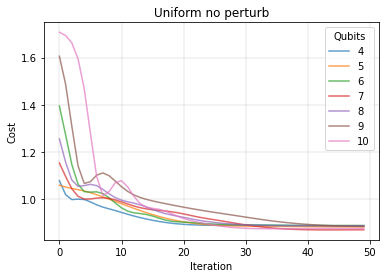

In [18]:
plot_costs(unif_wine_costs, qubits, title='Uniform no perturb', save='costs_uniform_no_perturb.png')

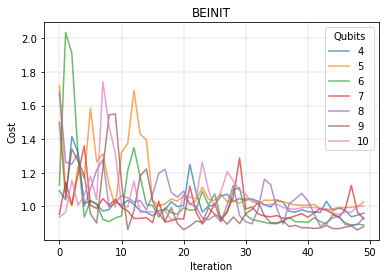

In [19]:
plot_costs(beinit_wine_costs, qubits, title='BEINIT', save='beinit_costs.png')

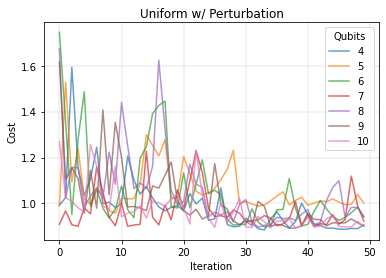

In [20]:
plot_costs(unifp_costs, qubits, title='Uniform w/ Perturbation', save='costs_uniform_perturb.png')

In [14]:
loadf = lambda fname: pickle.load(open(fname, 'rb'))

unif_ckpt = loadf('scaled_wine_uniform.pkl')
beinit_ckpt = loadf('scaled_wine_beinit_0.01.pkl')
unif_pert_ckpt = loadf('scaled_wine_uniform_pert.pkl')
unif_7_ckpt = loadf('wine_unif_qubit_7.pkl')
unifp_7_ckpt = loadf('wine_unif_pert_qubit_7.pkl')
beinit_7_ckpt = loadf('wine_beinit_qubit_7.pkl')

unif_ckpt[7] = unif_7_ckpt[7]
beinit_ckpt[7] = beinit_7_ckpt[7]
unif_pert_ckpt[7] = unifp_7_ckpt[7]


grad_var_unif_wine = unif_ckpt
grad_var_beinit_wine = beinit_ckpt
grad_var_unif_pert_wine = unif_pert_ckpt

In [12]:
loadf('wine_beinit_qubit_7.pkl')

{7: [0.016940951557210687,
  0.017116797689803773,
  0.023258219434333614,
  0.03472681403456086,
  0.03699566779799233,
  0.028538707545113482,
  0.01601520954616669,
  0.021287351574858872,
  0.015037952648151722]}

In [15]:
gv_avg_unif = [grad_var_unif_wine[k][-1] for k in grad_var_unif_wine]
p1 = np.polyfit(qubits, np.log(gv_avg_unif), 1)

In [16]:
gv_avg_beinit = [grad_var_beinit_wine[k][-1] for k in grad_var_beinit_wine]
pb = np.polyfit(qubits, np.log(gv_avg_beinit), 1)

In [17]:
gv_avg_unif_pert = [grad_var_unif_pert_wine[k][-1] for k in grad_var_unif_pert_wine]
pbu = np.polyfit(qubits, np.log(gv_avg_unif_pert), 1)

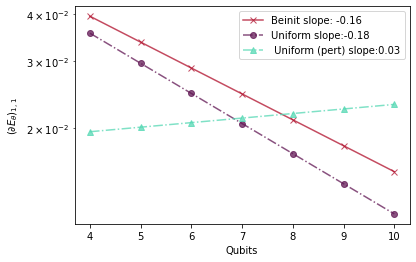

In [18]:
# plt.semilogy(qubits, gv_avg_beinit, label='beta')
plt.semilogy(qubits, np.exp(pb[0]*np.array(qubits, dtype='float') + pb[1]),'-x',
             c='#b00f2b', alpha=0.75,
             label=f"Beinit slope: {pb[0]:3.2f}")
# plt.semilogy(qubits, gv_avg_unif, '--', label='uniform')
plt.semilogy(qubits, np.exp(p1[0]*np.array(qubits, dtype='float') + p1[1]),'o-.',
             c='#611754', alpha=0.75,
             label=f"Uniform slope:{p1[0]:3.2f}")
# plt.semilogy(qubits, gv_avg_unif_pert, '--', label='uniform-perturb')
plt.semilogy(qubits, np.exp(pbu[0]*np.array(qubits, dtype='float') + pbu[1]),'^-.',
             c='#55d8b4',alpha=0.75,
             label=f" Uniform (pert) slope:{pbu[0]:3.2f}")
plt.legend()
plt.xlabel("Qubits")
plt.ylabel(r"($\partial E_{\theta})_{1, 1}$")
# plt.savefig('wine_beinit_experiments_covar.png', dpi=300, bbox_inches='tight')
plt.show()

({4: [0.027349205647715567,
   0.0338306516967747,
   0.012405819465600033,
   0.0194019538324698,
   0.020625981184621386,
   0.03024989175651412,
   0.023505577583150646,
   0.023019861857408234,
   0.020636448499351864],
  5: [0.02123641178939811,
   0.015224451192122655,
   0.021755806745153924,
   0.008529619460495262,
   0.010407611955275838,
   0.020319723201505456,
   0.01228662991211184,
   0.018410607056744775,
   0.01959851108798946],
  6: [0.017699427666519735,
   0.019262548475646162,
   0.021254900515574927,
   0.02438193433388685,
   0.025830163984853376,
   0.02498492991067093,
   0.026938106246656348,
   0.028326232427764386,
   0.027415570658898058],
  8: [0.01167310101383432,
   0.011157610655340657,
   0.008364774500021451,
   0.015904102603672213,
   0.018692212258536338,
   0.014747981177666876,
   0.018186536977195036,
   0.018934799698672865,
   0.01949428576296226],
  9: [0.012787718630505707,
   0.023719126440337385,
   0.020073765554753153,
   0.0175170617721

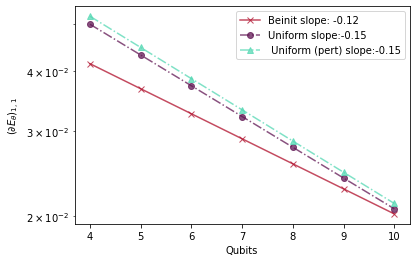

In [19]:
# plt.semilogy(qubits, gv_avg_beinit, label='beta')
plt.semilogy(qubits, np.exp(pb[0]*np.array(qubits, dtype='float') + pb[1]),'-x',
             c='#b00f2b', alpha=0.75,
             label=f"Beinit slope: {pb[0]:3.2f}")
# plt.semilogy(qubits, gv_avg_unif, '--', label='uniform')
plt.semilogy(qubits, np.exp(p1[0]*np.array(qubits, dtype='float') + p1[1]),'o-.',
             c='#611754', alpha=0.75,
             label=f"Uniform slope:{p1[0]:3.2f}")
# plt.semilogy(qubits, gv_avg_unif_pert, '--', label='uniform-perturb')
plt.semilogy(qubits, np.exp(pbu[0]*np.array(qubits, dtype='float') + pbu[1]),'^-.',
             c='#55d8b4',alpha=0.75,
             label=f" Uniform (pert) slope:{pbu[0]:3.2f}")
plt.legend()
plt.xlabel("Qubits")
plt.ylabel(r"($\partial E_{\theta})_{1, 1}$")
# plt.savefig('wine_beinit_experiments_covar.png', dpi=300, bbox_inches='tight')
plt.show()

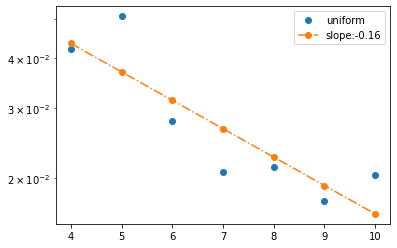

In [14]:
plt.semilogy(qubits, gv_avg_unif_pert, 'o', label='uniform')
plt.semilogy(qubits, np.exp(pbu[0]*np.array(qubits, dtype='float') + pbu[1]),'o-.', label=f"slope:{pbu[0]:3.2f}")
plt.legend()
plt.show()

In [19]:
with open('scaled_wine_beinit_0.01.pkl', 'wb') as of:
    pickle.dump(grad_var_beinit_wine, of)

In [20]:
with open('scaled_wine_uniform.pkl', 'wb') as of1:
    pickle.dump(grad_var_unif_wine, of1)

In [36]:
with open('scaled_wine_uniform_pert.pkl', 'wb') as of2:
    pickle.dump(grad_var_unif_pert_wine, of2)

## Expts With Layers

In [8]:
layers = [2, 4, 6, 8, 10, 15, 20, 25, 30]
cfgs = []
for l in layers:
    _cfg = {'X': X,
    'y': y,
    'opt': qml.NesterovMomentumOptimizer,
    'lr': 0.1,'layers': l}
    cfgs.append(_cfg)

In [9]:
unif_baseline_wine = {}
ckt = ckts[0]
for cfg in cfgs:
    print(f"Training with {cfg['layers']} layers")
    _ufvar = train_ckt(ckt, init_fn=init_uniform_norm, cfg=cfg)
    unif_baseline_wine[cfg['layers']] = _ufvar

save(unif_baseline_wine, 'wine_uniform_baseline_layer.pkl')

Training with 2 layers
Determined range: [-0.042862583296950515,0.954044201722873]


/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.31 | Train Acc: 0.5288 | Test Acc: 0.6154
1| Cost: 1.20 | Train Acc: 0.5288 | Test Acc: 0.6154
2| Cost: 1.09 | Train Acc: 0.5288 | Test Acc: 0.6154
3| Cost: 1.03 | Train Acc: 0.5288 | Test Acc: 0.6154
4| Cost: 1.01 | Train Acc: 0.5288 | Test Acc: 0.6154
5| Cost: 1.01 | Train Acc: 0.2212 | Test Acc: 0.1154
6| Cost: 1.02 | Train Acc: 0.4712 | Test Acc: 0.3846
7| Cost: 1.02 | Train Acc: 0.4712 | Test Acc: 0.3846
8| Cost: 1.02 | Train Acc: 0.4712 | Test Acc: 0.3846
9| Cost: 1.02 | Train Acc: 0.4712 | Test Acc: 0.3846
10| Cost: 1.01 | Train Acc: 0.4712 | Test Acc: 0.3846
11| Cost: 1.00 | Train Acc: 0.4712 | Test Acc: 0.3846
12| Cost: 0.99 | Train Acc: 0.5192 | Test Acc: 0.6154
13| Cost: 0.99 | Train Acc: 0.5288 | Test Acc: 0.6154
14| Cost: 0.99 | Train Acc: 0.5288 | Test Acc: 0.6154
15| Cost: 0.99 | Train Acc: 0.5288 | Test Acc: 0.6154
16| Cost: 0.99 | Train Acc: 0.5288 | Test Acc: 0.6154
17| Cost: 0.99 | Train Acc: 0.5288 | Test Acc: 0.6154
18| Cost: 0.99 | Train Acc: 0.5288 | T

In [16]:
beinit_pert_layer_wine = {}
ckt = ckts[0]
for cfg in cfgs:
    print(f"Training with {cfg['layers']} layers")
    _blvar = train_ckt_new(ckt, cfg=cfg)
    beinit_pert_layer_wine[cfg['layers']]=_blvar
    
save(beinit_pert_layer_wine, 'wine_beinit_layer.pkl')

Training with 2 layers
Found alpha:1.3373011193515794, beta:1.8891824875001
(2, 4, 3)


/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.04 | Train Acc: 0.4712 | Test Acc: 0.8462
1| Cost: 0.96 | Train Acc: 0.5288 | Test Acc: 0.1538
2| Cost: 1.00 | Train Acc: 0.5288 | Test Acc: 0.1538
3| Cost: 1.36 | Train Acc: 0.5288 | Test Acc: 0.1538
4| Cost: 1.46 | Train Acc: 0.5288 | Test Acc: 0.1538
5| Cost: 1.16 | Train Acc: 0.5288 | Test Acc: 0.1538
6| Cost: 1.20 | Train Acc: 0.4712 | Test Acc: 0.8462
7| Cost: 1.25 | Train Acc: 0.4712 | Test Acc: 0.8462
8| Cost: 1.02 | Train Acc: 0.1250 | Test Acc: 0.0385
9| Cost: 1.05 | Train Acc: 0.4712 | Test Acc: 0.8462
10| Cost: 0.97 | Train Acc: 0.8942 | Test Acc: 0.8846
11| Cost: 1.02 | Train Acc: 0.5288 | Test Acc: 0.1538
12| Cost: 1.15 | Train Acc: 0.5288 | Test Acc: 0.1538
13| Cost: 1.08 | Train Acc: 0.5288 | Test Acc: 0.1538
14| Cost: 1.03 | Train Acc: 0.5288 | Test Acc: 0.1538
15| Cost: 1.00 | Train Acc: 0.5288 | Test Acc: 0.1538
16| Cost: 0.94 | Train Acc: 0.9038 | Test Acc: 0.8462
17| Cost: 0.93 | Train Acc: 0.5288 | Test Acc: 0.1538
18| Cost: 1.01 | Train Acc: 0.5288 | T

/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.00 | Train Acc: 0.4327 | Test Acc: 0.5385
1| Cost: 1.33 | Train Acc: 0.5673 | Test Acc: 0.4615
2| Cost: 1.07 | Train Acc: 0.5673 | Test Acc: 0.4615
3| Cost: 1.00 | Train Acc: 0.5673 | Test Acc: 0.4615
4| Cost: 1.75 | Train Acc: 0.4327 | Test Acc: 0.5385
5| Cost: 1.10 | Train Acc: 0.4327 | Test Acc: 0.5385
6| Cost: 1.14 | Train Acc: 0.4327 | Test Acc: 0.5385
7| Cost: 0.99 | Train Acc: 0.5673 | Test Acc: 0.4615
8| Cost: 1.02 | Train Acc: 0.5673 | Test Acc: 0.4615
9| Cost: 1.01 | Train Acc: 0.5673 | Test Acc: 0.4615
10| Cost: 1.01 | Train Acc: 0.4327 | Test Acc: 0.5385
11| Cost: 1.21 | Train Acc: 0.4327 | Test Acc: 0.5385
12| Cost: 1.03 | Train Acc: 0.4327 | Test Acc: 0.5385
13| Cost: 1.03 | Train Acc: 0.4327 | Test Acc: 0.5385
14| Cost: 1.05 | Train Acc: 0.4327 | Test Acc: 0.5385
15| Cost: 1.05 | Train Acc: 0.4327 | Test Acc: 0.5385
16| Cost: 1.17 | Train Acc: 0.4327 | Test Acc: 0.5385
17| Cost: 1.03 | Train Acc: 0.4327 | Test Acc: 0.5385
18| Cost: 0.96 | Train Acc: 0.5673 | T

/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.20 | Train Acc: 0.5000 | Test Acc: 0.7308
1| Cost: 1.16 | Train Acc: 0.5000 | Test Acc: 0.7308
2| Cost: 1.01 | Train Acc: 0.5000 | Test Acc: 0.2692
3| Cost: 1.04 | Train Acc: 0.4038 | Test Acc: 0.6538
4| Cost: 1.12 | Train Acc: 0.5000 | Test Acc: 0.7308
5| Cost: 1.01 | Train Acc: 0.5000 | Test Acc: 0.7308
6| Cost: 1.05 | Train Acc: 0.5000 | Test Acc: 0.7308
7| Cost: 1.07 | Train Acc: 0.5000 | Test Acc: 0.2692
8| Cost: 1.07 | Train Acc: 0.5000 | Test Acc: 0.7308
9| Cost: 1.01 | Train Acc: 0.3173 | Test Acc: 0.5000
10| Cost: 0.96 | Train Acc: 0.5000 | Test Acc: 0.7308
11| Cost: 1.03 | Train Acc: 0.5000 | Test Acc: 0.2692
12| Cost: 1.00 | Train Acc: 0.5000 | Test Acc: 0.7308
13| Cost: 1.03 | Train Acc: 0.5000 | Test Acc: 0.7308
14| Cost: 1.04 | Train Acc: 0.5000 | Test Acc: 0.2692
15| Cost: 1.08 | Train Acc: 0.5000 | Test Acc: 0.7308
16| Cost: 1.32 | Train Acc: 0.5000 | Test Acc: 0.7308
17| Cost: 1.08 | Train Acc: 0.5000 | Test Acc: 0.7308
18| Cost: 1.01 | Train Acc: 0.5000 | T

/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 0.99 | Train Acc: 0.5673 | Test Acc: 0.5769
1| Cost: 1.24 | Train Acc: 0.4423 | Test Acc: 0.5000
2| Cost: 0.97 | Train Acc: 0.5577 | Test Acc: 0.5000
3| Cost: 0.99 | Train Acc: 0.5577 | Test Acc: 0.5000
4| Cost: 1.02 | Train Acc: 0.4423 | Test Acc: 0.5000
5| Cost: 1.00 | Train Acc: 0.4423 | Test Acc: 0.5000
6| Cost: 1.02 | Train Acc: 0.5577 | Test Acc: 0.5000
7| Cost: 1.07 | Train Acc: 0.4423 | Test Acc: 0.5000
8| Cost: 1.00 | Train Acc: 0.5577 | Test Acc: 0.5000
9| Cost: 0.99 | Train Acc: 0.5577 | Test Acc: 0.5000
10| Cost: 1.05 | Train Acc: 0.4423 | Test Acc: 0.5000
11| Cost: 0.98 | Train Acc: 0.5577 | Test Acc: 0.5000
12| Cost: 1.06 | Train Acc: 0.5577 | Test Acc: 0.5000
13| Cost: 1.16 | Train Acc: 0.4423 | Test Acc: 0.5000
14| Cost: 0.96 | Train Acc: 0.5577 | Test Acc: 0.5000
15| Cost: 1.04 | Train Acc: 0.4423 | Test Acc: 0.5000
16| Cost: 1.00 | Train Acc: 0.4423 | Test Acc: 0.5000
17| Cost: 0.99 | Train Acc: 0.5577 | Test Acc: 0.5000
18| Cost: 1.04 | Train Acc: 0.4423 | T

/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.03 | Train Acc: 0.4327 | Test Acc: 0.5385
1| Cost: 0.97 | Train Acc: 0.5673 | Test Acc: 0.4615
2| Cost: 0.98 | Train Acc: 0.5673 | Test Acc: 0.4615
3| Cost: 1.00 | Train Acc: 0.5673 | Test Acc: 0.4615
4| Cost: 1.00 | Train Acc: 0.4327 | Test Acc: 0.5385
5| Cost: 1.09 | Train Acc: 0.4327 | Test Acc: 0.5385
6| Cost: 1.04 | Train Acc: 0.4327 | Test Acc: 0.5385
7| Cost: 1.04 | Train Acc: 0.4327 | Test Acc: 0.5385
8| Cost: 1.04 | Train Acc: 0.4327 | Test Acc: 0.5385
9| Cost: 1.20 | Train Acc: 0.4327 | Test Acc: 0.5385
10| Cost: 1.19 | Train Acc: 0.4327 | Test Acc: 0.5385
11| Cost: 0.95 | Train Acc: 0.5673 | Test Acc: 0.4615
12| Cost: 0.98 | Train Acc: 0.5673 | Test Acc: 0.4615
13| Cost: 1.22 | Train Acc: 0.5673 | Test Acc: 0.4615
14| Cost: 1.08 | Train Acc: 0.5673 | Test Acc: 0.4615
15| Cost: 0.98 | Train Acc: 0.5673 | Test Acc: 0.4615
16| Cost: 1.04 | Train Acc: 0.4327 | Test Acc: 0.5385
17| Cost: 1.10 | Train Acc: 0.4327 | Test Acc: 0.5385
18| Cost: 1.22 | Train Acc: 0.4327 | T

/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.08 | Train Acc: 0.5769 | Test Acc: 0.4231
1| Cost: 0.99 | Train Acc: 0.5769 | Test Acc: 0.4231
2| Cost: 1.37 | Train Acc: 0.4231 | Test Acc: 0.5769
3| Cost: 0.95 | Train Acc: 0.5769 | Test Acc: 0.4231
4| Cost: 1.00 | Train Acc: 0.5769 | Test Acc: 0.4231
5| Cost: 1.01 | Train Acc: 0.5769 | Test Acc: 0.4231
6| Cost: 1.06 | Train Acc: 0.4231 | Test Acc: 0.5769
7| Cost: 1.02 | Train Acc: 0.4231 | Test Acc: 0.5769
8| Cost: 1.32 | Train Acc: 0.4231 | Test Acc: 0.5769
9| Cost: 1.00 | Train Acc: 0.5769 | Test Acc: 0.4231
10| Cost: 1.06 | Train Acc: 0.4231 | Test Acc: 0.5769
11| Cost: 1.65 | Train Acc: 0.4231 | Test Acc: 0.5769
12| Cost: 1.01 | Train Acc: 0.5769 | Test Acc: 0.4231
13| Cost: 1.14 | Train Acc: 0.4231 | Test Acc: 0.5769
14| Cost: 0.98 | Train Acc: 0.5769 | Test Acc: 0.4231
15| Cost: 0.95 | Train Acc: 0.5769 | Test Acc: 0.4231
16| Cost: 0.98 | Train Acc: 0.5769 | Test Acc: 0.4231
17| Cost: 0.98 | Train Acc: 0.5769 | Test Acc: 0.4231
18| Cost: 1.22 | Train Acc: 0.4231 | T

/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.01 | Train Acc: 0.5481 | Test Acc: 0.5385
1| Cost: 1.00 | Train Acc: 0.5481 | Test Acc: 0.5385
2| Cost: 1.06 | Train Acc: 0.4519 | Test Acc: 0.4615
3| Cost: 1.05 | Train Acc: 0.5481 | Test Acc: 0.5385
4| Cost: 1.05 | Train Acc: 0.4519 | Test Acc: 0.4615
5| Cost: 1.03 | Train Acc: 0.5481 | Test Acc: 0.5385
6| Cost: 0.97 | Train Acc: 0.5481 | Test Acc: 0.5385
7| Cost: 1.21 | Train Acc: 0.4519 | Test Acc: 0.4615
8| Cost: 1.00 | Train Acc: 0.5481 | Test Acc: 0.5385
9| Cost: 1.05 | Train Acc: 0.5481 | Test Acc: 0.5385
10| Cost: 1.02 | Train Acc: 0.5481 | Test Acc: 0.5385
11| Cost: 0.99 | Train Acc: 0.5481 | Test Acc: 0.5385
12| Cost: 1.01 | Train Acc: 0.5481 | Test Acc: 0.5385
13| Cost: 1.07 | Train Acc: 0.4519 | Test Acc: 0.4615
14| Cost: 1.03 | Train Acc: 0.4519 | Test Acc: 0.4615
15| Cost: 1.12 | Train Acc: 0.4519 | Test Acc: 0.4615
16| Cost: 1.06 | Train Acc: 0.4519 | Test Acc: 0.4615
17| Cost: 0.99 | Train Acc: 0.4519 | Test Acc: 0.4615
18| Cost: 1.04 | Train Acc: 0.4519 | T

/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.06 | Train Acc: 0.4712 | Test Acc: 0.3846
1| Cost: 1.06 | Train Acc: 0.4712 | Test Acc: 0.3846
2| Cost: 1.03 | Train Acc: 0.4712 | Test Acc: 0.3846
3| Cost: 1.00 | Train Acc: 0.5481 | Test Acc: 0.6154
4| Cost: 1.00 | Train Acc: 0.5288 | Test Acc: 0.6154
5| Cost: 0.97 | Train Acc: 0.5288 | Test Acc: 0.6154
6| Cost: 1.18 | Train Acc: 0.5288 | Test Acc: 0.6154
7| Cost: 0.97 | Train Acc: 0.5288 | Test Acc: 0.6154
8| Cost: 0.98 | Train Acc: 0.5288 | Test Acc: 0.6154
9| Cost: 0.97 | Train Acc: 0.8942 | Test Acc: 0.8846
10| Cost: 1.02 | Train Acc: 0.4712 | Test Acc: 0.3846
11| Cost: 1.10 | Train Acc: 0.4712 | Test Acc: 0.3846
12| Cost: 1.02 | Train Acc: 0.5288 | Test Acc: 0.6154
13| Cost: 1.16 | Train Acc: 0.5288 | Test Acc: 0.6154
14| Cost: 1.13 | Train Acc: 0.4712 | Test Acc: 0.3846
15| Cost: 1.04 | Train Acc: 0.5288 | Test Acc: 0.6154
16| Cost: 1.07 | Train Acc: 0.4712 | Test Acc: 0.3846
17| Cost: 1.10 | Train Acc: 0.4712 | Test Acc: 0.3846
18| Cost: 1.05 | Train Acc: 0.2981 | T

/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.02 | Train Acc: 0.4135 | Test Acc: 0.6154
1| Cost: 0.97 | Train Acc: 0.5865 | Test Acc: 0.3846
2| Cost: 1.16 | Train Acc: 0.4135 | Test Acc: 0.6154
3| Cost: 1.35 | Train Acc: 0.4135 | Test Acc: 0.6154
4| Cost: 0.98 | Train Acc: 0.5865 | Test Acc: 0.3846
5| Cost: 1.25 | Train Acc: 0.4135 | Test Acc: 0.6154
6| Cost: 1.00 | Train Acc: 0.5865 | Test Acc: 0.3846
7| Cost: 1.07 | Train Acc: 0.4135 | Test Acc: 0.6154
8| Cost: 0.95 | Train Acc: 0.5865 | Test Acc: 0.3846
9| Cost: 1.21 | Train Acc: 0.4135 | Test Acc: 0.6154
10| Cost: 1.36 | Train Acc: 0.4135 | Test Acc: 0.6154
11| Cost: 1.06 | Train Acc: 0.4135 | Test Acc: 0.6154
12| Cost: 1.07 | Train Acc: 0.5865 | Test Acc: 0.3846
13| Cost: 0.96 | Train Acc: 0.5865 | Test Acc: 0.3846
14| Cost: 0.96 | Train Acc: 0.5865 | Test Acc: 0.3846
15| Cost: 1.33 | Train Acc: 0.4135 | Test Acc: 0.6154
16| Cost: 1.12 | Train Acc: 0.4135 | Test Acc: 0.6154
17| Cost: 0.98 | Train Acc: 0.5865 | Test Acc: 0.3846
18| Cost: 1.22 | Train Acc: 0.4135 | T

In [11]:
unif_pert_wine = {}
ckt = ckts[0]
for cfg in cfgs:
    print(f"Training with {cfg['layers']} layers")
    _ufvar = train_ckt(ckt, init_fn=init_uniform_norm, cfg=cfg)
    unif_pert_wine[cfg['layers']] = _ufvar

save(unif_pert_wine, 'wine_uniform_pert_layer.pkl')

Training with 2 layers
Determined range: [-0.042862583296950515,0.954044201722873]


/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.74 | Train Acc: 0.5192 | Test Acc: 0.6538
1| Cost: 1.62 | Train Acc: 0.5192 | Test Acc: 0.6538
2| Cost: 1.42 | Train Acc: 0.5192 | Test Acc: 0.6538
3| Cost: 1.20 | Train Acc: 0.5192 | Test Acc: 0.6538
4| Cost: 1.07 | Train Acc: 0.5192 | Test Acc: 0.6538
5| Cost: 1.06 | Train Acc: 0.4231 | Test Acc: 0.1538
6| Cost: 1.09 | Train Acc: 0.4808 | Test Acc: 0.3462
7| Cost: 1.12 | Train Acc: 0.4808 | Test Acc: 0.3462
8| Cost: 1.11 | Train Acc: 0.4808 | Test Acc: 0.3462
9| Cost: 1.09 | Train Acc: 0.4808 | Test Acc: 0.3462
10| Cost: 1.06 | Train Acc: 0.4808 | Test Acc: 0.3462
11| Cost: 1.03 | Train Acc: 0.4808 | Test Acc: 0.3462
12| Cost: 1.01 | Train Acc: 0.4808 | Test Acc: 0.3462
13| Cost: 0.99 | Train Acc: 0.5192 | Test Acc: 0.6538
14| Cost: 0.99 | Train Acc: 0.5192 | Test Acc: 0.6538
15| Cost: 0.98 | Train Acc: 0.5192 | Test Acc: 0.6538
16| Cost: 0.97 | Train Acc: 0.5192 | Test Acc: 0.6538
17| Cost: 0.97 | Train Acc: 0.5192 | Test Acc: 0.6538
18| Cost: 0.96 | Train Acc: 0.5192 | T

In [17]:
# baseline 
wine_baseline = load('wine_uniform_baseline_layer.pkl')
gv_unif_layer = [wine_baseline[k][-1] for k in wine_baseline]

# beinit
beinit_layer = load('wine_beinit_layer.pkl')
gv_beinit_layer = [beinit_layer[k][-1] for k in beinit_layer]

# unif-pert
unif_pert_layer = load('wine_uniform_pert_layer.pkl')
gv_unif_pert_layer = [unif_pert_layer[k][-1] for k in unif_pert_layer]

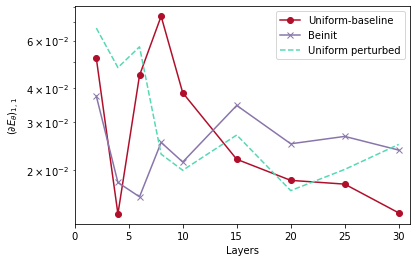

In [20]:
plt.semilogy(layers, gv_unif_layer, '-o', c='#b00f2b', label='Uniform-baseline')
plt.semilogy(layers, gv_beinit_layer, '-x', c='#8975aa', label='Beinit')
plt.semilogy(layers, gv_unif_pert_layer, '--', c='#55d8b4', label='Uniform perturbed')
plt.xlabel("Layers")
plt.ylabel(r"($\partial E_{\theta})_{1, 1}$")
plt.legend()
plt.xlim(0, 31)
plt.legend()
plt.savefig('wine_expt_layers.png', dpi=300, bbox_inches='tight')

In [ ]:
gv_unif_baseline_lavg = [unif_baseline_wine[k][-1] for k in unif_baseline_wine]
plt.semilogy(layers, gv_unif_baseline_lavg, '-o')